## Example usage of Tempestpy

In [1]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat

import gymnasium as gym

from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import tempfile, datetime, shutil

import time
import os

from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, ImageRecorderCallback, InfoCallback

import os, sys
from copy import deepcopy

from PIL import Image

pygame 2.6.1 (SDL 2.28.4, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-11-18 09:48:14.483116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 09:48:14.491463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731923294.501077  121579 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731923294.504096  121579 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 09:48:14.515882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

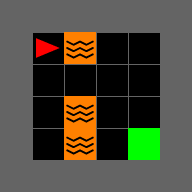



Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0025315284729003906 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0001392364501953125 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.0013279914855957031 seconds.
Write to file shielding_files_20241118T094818_em6jy828/shield.


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0009472370147705078 seconds.
LOG: Starting with model checking...
Elapsed time is 8.153915405273438e-05 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.0009839534759521484 seconds.
Symbolic Description of the Model:
Write to file shielding_files_20241118T094818_mmto3b7e/shield.


AttributeError: 'MiniGridShieldHandler' object has no attribute 'print_symbolic_model'

In [2]:
os.environ['M2P_BINARY'] = '/opt/Minigrid2PRISM/build/main'
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")

def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7

def main():
    env = "MiniGrid-LavaGapS6-v0"

    # TODO Change the safety specification
    formula = "Pmax=? [G !AgentIsOnLava]"
    value_for_training = 1.0
    shield_comparison =  "absolute"
    shielding = ShieldingConfig.Training
    
    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])
    

    env = gym.make(env, render_mode="rgb_array")
    image_env = RGBImgObsWrapper(env, TILE_PIXELS)
    env = RGBImgObsWrapper(env, 8)
    env = ImgObsWrapper(env)
    env = MiniWrapper(env)

    
    env.reset()
    Image.fromarray(env.render()).show()
    input("") 
    
    shield_handlers = dict()
    if shield_needed(shielding):
        for value in [0.0, 1.0]:
            shield_handler = MiniGridShieldHandler(GRID_TO_PRISM_BINARY, "grid.txt", "grid.prism", formula, shield_value=value, shield_comparison=shield_comparison, nocleanup=True, prism_file=None)
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
            shield_handlers[value] = shield_handler

    print("Symbolic Description of the Model:")
    shield_handlers[1.0].print_symbolic_model()
    input("")

    if shield_needed(shielding):
        for value in [1.0]:
            create_shield_overlay_image(image_env, shield_handlers[value].create_shield())
            print(f"The shield for shield_value = {value}")
            input("")
    
    if shielding == ShieldingConfig.Training:
        env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
        env = ActionMasker(env, mask_fn)
        print("Training with shield:")
        create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
    elif shielding == ShieldingConfig.Disabled:
        env = ActionMasker(env, nomask_fn)
    else:
        assert(False) 
    model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
    model.set_logger(logger)
    steps = 20_000

 
    model.learn(steps,callback=[InfoCallback()])



if __name__ == '__main__':
    main()